### The QR algorithm for nonsymmetric matrices

The QR algorithm computes the real Schur decomposition of a nonsymmetric matrix, $A = U T U^T$, in two phases:
* Reduction to Hessenberg form by orthogonal similarity transforms, i.e., $$H = O^T A O.$$
* Shifted QR iterations on the resulting Hessenberg matrix, i.e., $A^{(0)} = H$ and for $k=1,2,3,\ldots$  $$Q^{(k)}R^{(k)} = A^{(k-1)}-\mu^{(k)}I,$$ and $$A^{(k)} = R^{(k)}Q^{(k)} + \mu^{(k)}I.$$

With the right choice of shifts, $\mu^{(1)},\mu^{(2)},\mu^{(3)},\ldots,$ the iterates $A^{(k)}$ typically converge to $T$. The eigenvalues of $A$ can be extracted directly from the diagonal of $T$ and the eigenvectors of $A$ can be computed with some additional postprocessing.

This notebook walks through the two phases and introduces two concepts that make QR iterations fly: _deflation_ and _implicit double shifts_ ("bulge-chasing"). 

Here's our generic dense matrix $A$ with real entries (the blue blocks in the spy plot denote nonzero entries).

10×10 Matrix{Float64}:
 0.596743   0.953508   0.160266   …  0.685694   0.635918   0.585804
 0.974072   0.280291   0.689595      0.464274   0.856417   0.622869
 0.639517   0.88061    0.554528      0.0321642  0.309086   0.210872
 0.993187   0.871752   0.656522      0.100221   0.358144   0.0672854
 0.780664   0.570967   0.464813      0.607093   0.7083     0.0611541
 0.193732   0.635558   0.0718944  …  0.743273   0.141546   0.746133
 0.338093   0.271387   0.791033      0.182219   0.832148   0.507381
 0.587215   0.637329   0.957485      0.413398   0.677972   0.0895093
 0.0907199  0.909522   0.441795      0.69461    0.0862548  0.839091
 0.823763   0.0253694  0.602349      0.475098   0.227959   0.657145

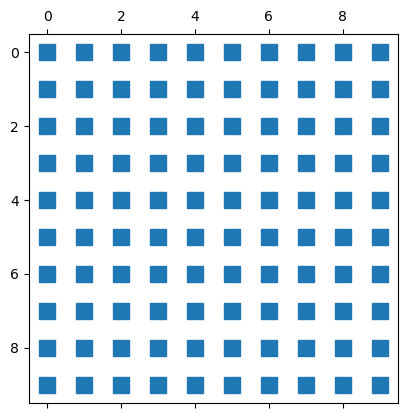

PyObject <matplotlib.lines.Line2D object at 0x000000006815B8B0>

In [1]:
using LinearAlgebra
using PyPlot

n = 10
A = rand(n,n)
display(A)
spy(abs.(A) .> 1e-12, markersize = 12)

Both phases lean heavily on Householder reflections! The orthogonal matrices $O$ and $Q^{(k)}$ above will be constructed as a sequence of Householder transformations $$O = O_1 O_2 \cdots O_{n-2},$$ and $$Q^{(k)} = Q_1^{(k)} Q_2^{(k)} \cdots Q_{n-1}^{(k)}.$$ 


One can also use Givens rotations at a slightly increased cost in flops (Pset 3, problem 10.4).

In [2]:
# get reflector for Householder transformation
function reflector( x )
    v = zeros(length(x))
    v[1] = sign(x[1]) * norm(x) + x[1]
    v[2:end] = x[2:end] 
    v = v / norm(v)
    return v
end

# apply Householder transformation to A from left, i.e., QA = (I-vv')A 
function hhtLeft( A, v)
    return A - 2 * v * (transpose(v) * A)
end

# apply Householder transformation to A from right, i.e., AQ = A(I-vv') 
function hhtRight( A, v)
    return A - 2 * (A * v) * transpose(v)
end

# Householder reflection "zeros out" all but first entry
a = rand(10)
v = reflector(a)
Qa = hhtLeft(a, v)
display([norm(a) norm(Qa)])     # length of a is preserved by orthogonal transformation
display(Qa)                     # all entries but first are now (numerically) zero

1×2 Matrix{Float64}:
 1.70181  1.70181

10-element Vector{Float64}:
 -1.7018074194650175
  0.0
  0.0
  0.0
  0.0
 -1.1102230246251565e-16
  0.0
  0.0
  0.0
  0.0

### Phase 1: Reduction to upper Hessenberg form

In Phase 1, we apply $n-2$ orthogonal transformations on both the left and right of A to make it upper Hessenberg. Upper Hessenberg form means that the matrix is "almost" triangular, except for nonzero entries on the first subdiagonal. Upper Hessenberg form can be achieved directly with a finite sequence of Householder reflections and it makes subsquent QR iterations an order of magnitude faster (among other advantages).

Here's what A looks like after applying the first pair, $A_1 = O_1^T A O_1$. Recall that the blue blocks represent nonzero entries.

10×10 Matrix{Float64}:
  0.596743  -1.25018   -0.308241   …   0.255504    0.569457   -0.0176796
 -2.03399    3.41012   -0.660115      -0.0199233  -1.25279     0.410544
  0.0       -0.121033  -0.0868371     -0.396207   -0.18961    -0.290792
  0.0        0.244933  -0.14208       -0.383744   -0.388333   -0.45747
  0.0       -0.198901  -0.221831       0.172579    0.113196   -0.427218
  0.0       -1.16798   -0.44132    …   0.320664   -0.0547675   0.183356
  0.0       -0.690966   0.359946      -0.128739    0.55545     0.12364
  0.0       -0.206194   0.384774       0.0349365   0.22236    -0.350258
  0.0       -1.48868   -0.128838       0.193419   -0.0525304   0.150087
  0.0        0.110407   0.068586       0.191781   -0.372935    0.387567

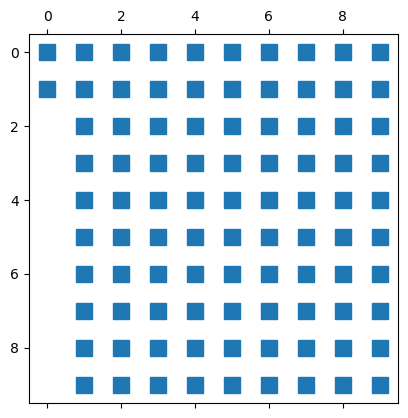

PyObject <matplotlib.lines.Line2D object at 0x00000000681E0580>

In [3]:
# orthogonal transform from the left introduces zeros in first column below first subdiagonal
A1 = A
v1 = reflector(A1[2:end,1])
A1[2:end,:] = hhtLeft(A1[2:end,:], v1)

# same orthogonal transform applied from the right doesn't affect zeros in first column
A1[:,2:end] = hhtRight(A1[:,2:end], v1)

display(A1)
spy(abs.(A1).>1e-12, markersize = 12)

And after applying the second pair, $A_2 = O_2^T A_1 O_2$.

10×10 Matrix{Float64}:
  0.596743  -1.25018      -0.757457   -0.642306   …   0.262262     0.00510325
 -2.03399    3.41012       1.81005    -0.0852633      0.436418     0.285265
  0.0        2.05589       0.657158    0.232917       0.108233    -0.217807
  0.0        5.55112e-17   0.0906292  -0.573999      -0.205463    -0.481729
  0.0       -5.55112e-17   0.108026    0.24052        0.319494    -0.433831
  0.0       -2.22045e-16  -0.026432    0.213825   …   0.11578      0.221718
  0.0       -1.11022e-16  -0.0295866   0.750071       0.222118     0.178538
  0.0       -5.55112e-17  -0.377386   -0.247072      -0.318819    -0.301117
  0.0       -2.22045e-16   0.155633    0.0499277     -0.00224333   0.211374
  0.0        2.77556e-17   0.417369    0.429849      -0.123723     0.364263

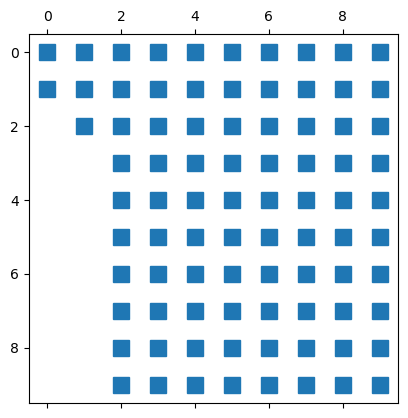

PyObject <matplotlib.lines.Line2D object at 0x0000000068240070>

In [4]:
# orthogonal transform from the left introduces zeros in second column below subdiagonal
A2 = A1
v2 = reflector(A2[3:end,2])
A2[3:end,:] = hhtLeft(A2[3:end,:], v2)

# same orthogonal transform applied from the right doesn't affect zeros in first or second column
A2[:,3:end] = hhtRight(A2[:,3:end], v2)

display(A2)
spy(abs.(A2).>1e-12, markersize = 12)

After applying the remaining $n-4$ transformations, we obtain the upper Hessenberg matrix $$ H = O_{n-2}^T\cdots O_2^T O_1^T A O_1 O_2 \cdots O_{n-2}.$$

10×10 Matrix{Float64}:
  0.596743  -1.25018      -0.757457     …   0.533076   -0.170799    0.0412546
 -2.03399    3.41012       1.81005          0.301308   -0.2674     -0.277479
  0.0        2.05589       0.657158        -0.0607439   0.598446    0.028592
  0.0       -1.0241e-17   -0.60191          0.130176    0.364182    0.28029
  0.0       -3.85641e-17  -2.56192e-17     -0.238278   -0.231879   -0.325169
  0.0        2.14035e-16   8.50065e-18  …   0.0249621  -0.0326442   0.46533
  0.0       -6.37623e-17  -1.92207e-17      0.174885   -0.148479   -0.134659
  0.0       -1.71321e-16  -1.64916e-17     -0.111072   -0.446685   -0.135896
  0.0        6.2973e-17   -3.12278e-17      0.238548    0.517943   -0.06716
  0.0        1.90167e-16  -3.06745e-17      0.0        -0.203549   -0.20485

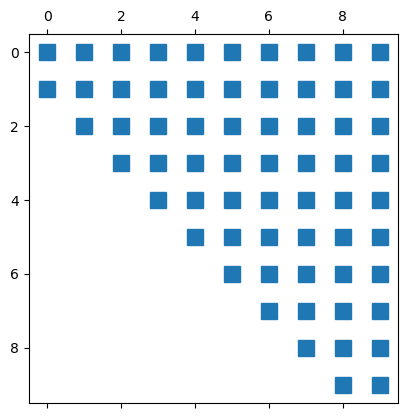

PyObject <matplotlib.lines.Line2D object at 0x0000000000D2E7C0>

In [5]:
# orthogonal similarity transforms convert to upper Hessenberg
H = A2;
for j=3:n-2
    vj = reflector(H[j+1:end,j])                    # get Householder reflector
    H[j+1:end,:] = hhtLeft(H[j+1:end,:], vj)        # orthogonal transform from left
    H[:,j+1:end] = hhtRight(H[:,j+1:end], vj)       # same orthgonal transform from right
end

display(H)
spy(abs.(H).>1e-12, markersize = 12)

Of course, by similarity we know that $H = O^T A O$ still has the same eigenvalues as $A$.

In [6]:
[eigen(A).values eigen(H).values]

10×2 Matrix{ComplexF64}:
  -1.13088+0.0im        -1.13088+0.0im
 -0.402147+0.0im       -0.402147+0.0im
 -0.247587-0.635938im  -0.247587-0.635938im
 -0.247587+0.635938im  -0.247587+0.635938im
 -0.197061+0.0im       -0.197061+0.0im
  0.374731-0.571987im   0.374731-0.571987im
  0.374731+0.571987im   0.374731+0.571987im
  0.500927-0.111393im   0.500927-0.111393im
  0.500927+0.111393im   0.500927+0.111393im
   5.02014+0.0im         5.02014+0.0im

### Phase 2: Hessenberg QR iterations

During a single unshifted QR iteration, the QR step triangularizes $A^{(k-1)}$ and the RQ step restores $A^{(k)}$ to upper Hessenberg form. To triangularize the upper Hessenberg matrix $A^{(k)}$, we use $(n-1)$ $2\times2$ Householder transformations to introduce zeros on the subdiagonal: $$ R = (Q^{(k)}_{n-1})^T\cdots (Q^{(k)}_1)^T A^{(k-1)}.$$

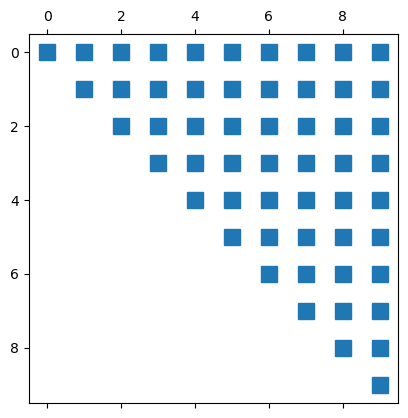

PyObject <matplotlib.lines.Line2D object at 0x000000000171FE80>

In [11]:
function hessQR( A )    # compute QR factorization of upper Hessenberg matrix with 2 x 2 Householder transformations
    R = copy(A)
    n = size(R,2)
    V = zeros(2,n-1)
    for j = 1:n-1
        v = reflector( R[j:j+1,j])
        R[j:j+1,:] = hhtLeft(R[j:j+1,:], v)
        V[:,j] = v
    end
    return R, V         # outputs triangular factor and sequence of 2 x 2 Householder reflectors for orthogonal factor
end

H1 = H                                      # First, triangularize upper Hessenberg matrix via QR factorization
R, V = hessQR( H1 )
spy(abs.(R).>1e-12, markersize = 12)


Applying the same $2\times 2$ Householder transformations on the right mixes two columns at a time, reintroducing zeros on the subdiagonal. This RQ step transforms $R$ to the upper Hessenber matrix $A^{(k)}$: $$ A^{(k)} = R^{(k)} Q^{(k)}_1\cdots Q^{(k)}_{n-1}.$$

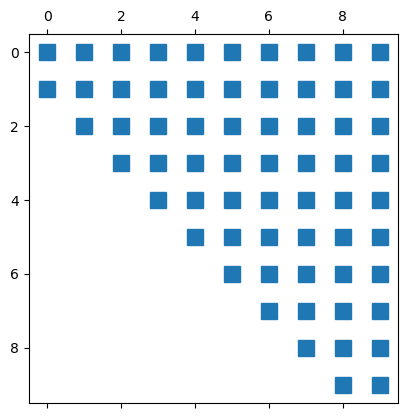

PyObject <matplotlib.lines.Line2D object at 0x0000000000E6CCA0>

In [12]:
function hessRQ( R, V )  # compute RQ by applying 2 x 2 Householder transformations from the right
    A = copy(R)
    n = size(A,2)
    for j = 1:n-1
        A[:,j:j+1] = hhtRight(A[:,j:j+1], V[:,j])
    end
    return A
end

H2 = hessRQ( R, V )                     # Second, return to upper Hessenberg form by completing similarity transform (apply Q from right)
figure(2)
spy(abs.(H2).>1e-12, markersize = 12)

Notice that combining the two steps reveals a similarity transform: $$A^{(k)} = R^{(k)} Q^{(k)}_1\cdots Q^{(k)}_{n-1} = (Q^{(k)}_{n-1})^T\cdots (Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1\cdots Q^{(k)}_{n-1}.$$ The eigenvalues of $A^{(k)}$ are the eigenvalues of $A^{(k-1)}$, and consequently, the eigenvalues of the initial Hessenberg matrix $H$ and the original matrix $A$.

### The real Schur form

Applying QR iterations to $H$ tends to drive the subdiagonal entires to zero, so that (aggregating the orthogonal transformations from Phase 1 and Phase 2 into an orthogonal matrix $U$) we recover approximations to the _real Schur form_ of A, $$ U^T A U = T.$$

If $A$ has real eigenvalues, $T$ is a triangular matrix with the eigenvalues of $A$ on its diagonal. For example, $$T = \begin{bmatrix} \lambda_1 & X & X & X \\ 0 & \lambda_2 & X & X \\ 0 & 0 & \lambda_3 & X \\ 0 & 0 & 0 & \lambda_4 \end{bmatrix}.$$

However, notice above that $A$ may have complex eigenvalues even though the entries of $A$ are real. This is analogous (in fact, equivalent) to the fact that polynomials with real coefficients may have complex roots. Such complex eigenvalues (or roots) always come in complex conjugate pairs. In this case, the real Schur form contains $2\times 2$ blocks along the diagonal corresponding precisely to the complex eigenvalues, e.g., $$T = \begin{bmatrix} \lambda_1 & X & X & X \\ 0 & a & b & X \\ 0 & c & d & X \\ 0 & 0 & 0 & \lambda_4 \end{bmatrix}.$$ The eigenvalues of the $2\times 2$ diagonal block $\smash{\begin{bmatrix} a & b \\ c & d\end{bmatrix}}$ comprise a conjugate pair of complex eigenvalues of $A$, while $\lambda_1$ and $\lambda_4$ are real eigenvalues of $A$.

In general, $T$ is a real block upper triangular matrix of the form $$T = \begin{bmatrix} T_{11} & T_{12} & \cdots & T_{1n} \\ 0 & T_{22} & \cdots & T_{2n} \\ \vdots & \ddots  & \ddots & \vdots \\ 0 & \cdots & 0 & T_{nn} \end{bmatrix},$$
where the block diagonal entries $T_{11},\ldots,T_{nn}$ are $1\times 1$ or $2\times 2$, corresponding to the real and complex eigenvalues of A, respectively.





10-element Vector{ComplexF64}:
   5.0201430332243175 + 0.0im
  -1.1308791303789132 + 0.0im
  -0.2475866142161597 + 0.6359382912707199im
  -0.2475866142161597 - 0.6359382912707199im
   0.3747313744107058 + 0.5719869329089322im
   0.3747313744107058 - 0.5719869329089322im
   0.5009265862450623 + 0.11139268948728849im
   0.5009265862450623 - 0.11139268948728849im
 -0.40214703762698834 + 0.0im
 -0.19706148707858062 + 0.0im

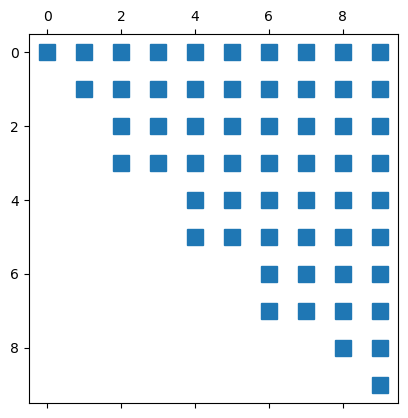

PyObject <matplotlib.lines.Line2D object at 0x00000000017A2F10>

In [13]:
F = schur(A)
display(F.values)                           # eigenvalues extracted from Schur decomposition
spy(abs.(F.T).>1e-12, markersize = 12)      # visualize block tridiagonal structure


If we run some simple (unshifted) QR iterations on $H$, the iterates tend to approach the real Schur form. However, convergence can be very slow and is not guaranteed. To visualize, we can plot the magnitude of the subdiagonal entries at each iteration: we hope that $n - \#(\text{complex eigenvalues})/2$ of these entries will converge to zero to match the real Schur form. But some of them may converge much slower than others (or not at all).

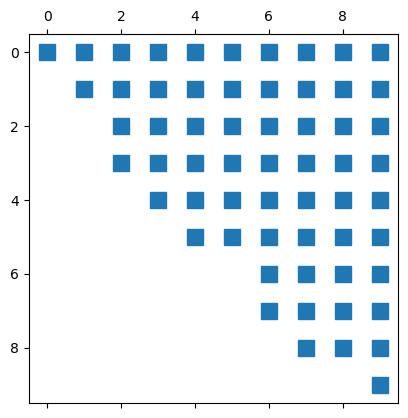

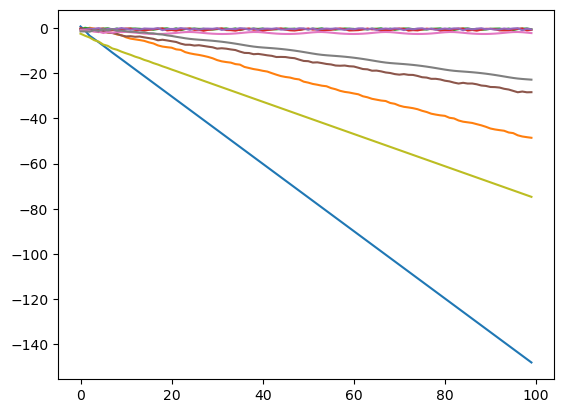

9-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000185C700>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185C760>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185C880>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185C9A0>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185CAC0>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185CBE0>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185CD00>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185CE20>
 PyObject <matplotlib.lines.Line2D object at 0x000000000185CF40>

In [14]:
Hk = H
n_iter = 100
Hksd1 = zeros(n-1, n_iter)
for k = 1:n_iter
   QR = qr(Hk)                            # using LinearAlgebra.qr for convenience here, in practice (and below)
   Hk = QR.R*QR.Q                         # we will want to take advantage of Hessenberg structure for faster QR!
   Hksd1[:,k] = diag(Hk, -1)
end
figure()
spy(abs.(Hk).>1e-12, markersize = 12)     # visual check on convergence to real Schur form
figure()
plot(log.(abs.(transpose(Hksd1))))        # subdiagonal elements driven to zero?


Now, let's take a look at two techniques designed to accelerate the Hessenberg QR iterations: **deflation** and **shift** strategies. These ideas work powerfully in tandem with each other to make the Phase 2 iterations fly.

### Deflation

When a subdiagonal entry in the Hessenberg matrix $H$ is zero, the eigenvalue problem can be _reduced_ to two smaller eigenvalue problems. We have that $$H = \begin{bmatrix} H_{11} & H_{12} \\ & H_{22} \end{bmatrix},$$ where $H_{11}$ and $H_{22}$ are upper Hessenberg. In analogy with with the fact that the eigenvalues of a triangular matrix must lie on the diagonal, the eigenvalues of a _block triangular_ matrix are simply the eigenvalues of the diagonal blocks. Actually, we have already seen an example of this with the real Schur form! Consequently, the eigenvalues of $H$ are precisely the eigenvalues of $H_{11}$ together with the eigenvalues of $H_{22}$.




10×2 Matrix{ComplexF64}:
  -2.34167+0.0im       -2.34167+0.0im
  -1.58187+0.0im       -1.58187+0.0im
  -1.16056+0.0im       -1.16056+0.0im
 -0.648278+0.0im      -0.648278+0.0im
 -0.645407+0.0im      -0.645407+0.0im
 -0.596147-1.35397im  -0.596147-1.35397im
 -0.596147+1.35397im  -0.596147+1.35397im
  0.658336+0.0im       0.658336+0.0im
   1.69829+0.0im        1.69829+0.0im
   2.11882+0.0im        2.11882+0.0im

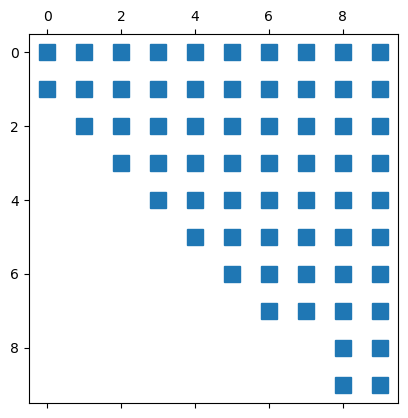

PyObject <matplotlib.lines.Line2D object at 0x0000000001C81F40>

In [15]:
# upper Hessenberg matrix with zero on subdiagonal
HH = randn(n,n)
HH = convert(Array, UpperHessenberg(HH))
HH[n-1,n-2] = 0

# compare eigenvalues and visualize block triangular structure of HH,
# note that eigenvalues are sorted by real part
HHEvals = sort(eigen(HH).values, by = x -> real(x))
HHBlockEvals = sort([eigen(HH[1:n-2,1:n-2]).values; eigen(HH[n-1:end,n-1:end]).values], by = x -> real(x))
display([HHEvals HHBlockEvals])
spy(abs.(HH).>1e-15, markersize = 12)

When a subdiagonal entry in the last or second to last row is zero, then $H_{22}$ is a $1\times 1$ or $2\times 2$ matrix and we can go beyond reduction to _deflation_. If $H_{22}$ is $1\times 1$, then $H_{22}$ itself is an eigenvalue of $A$ and if $H_{22}$ is $2\times 2$, we can find its eigenvalues by calculating the roots of the characteristic polynomial (e.g., with the quadratic formula). We then proceed with QR iterations on the $H_{11}$ block. We don't need to do any further computations with the blocks $H_{12}$ or $H_{22}$!


In the next section, we will discuss shifts for the Hessenberg QR iterations whose purpose is to rapidly shrink the subdiagonal entries in the last two rows of $A^{(k)}$. When one of these entries is close enough to zero, we deflate this small lower right block and continue with QR iterations on the large upper left block. We repeat this procedure until the upper left block is a $2\times 2$ matrix, at which point we can calculate the last two eigenvalues analytically.

In [16]:
# calculate eigenvalues of 2x2 matrix via numerically
# stable quadratic formula for roots of characteristic
# polynomial.
function eig2x2( A )
    tr = A[1,1]+A[2,2]
    det = A[1,1]*A[2,2]-A[1,2]*A[2,1]
    if tr^2 >= 4 * det                      # real eigenvalues
        lam = zeros(2)
        if tr <= 0                          # avoid possible cancellation
            d = tr - sqrt(tr^2 - 4 * det)
            lam[1] = d / 2.0
            lam[2] = 2.0 * det / d
        else
            d = tr + sqrt(tr^2 - 4 * det)
            lam[1] = 2.0 * det / d
            lam[2] = d / 2.0
        end
    else                                    # complex eigenvalues
        lam = 1im*zeros(2)
        d = sqrt(4 * det - tr^2)
        lam[1] = (tr - 1im * d) / 2.0
        lam[2] = (tr + 1im * d) / 2.0
    end
    return lam
end

# eigenvalues of the lower right 2x2 block in the previous example (test against eigen().values)
evals = eig2x2(HH[end-1:end,end-1:end])
display(evals)
eigen(HH[end-1:end,end-1:end]).values

2-element Vector{Float64}:
 -0.6482784032291332
  1.698287308681436

2-element Vector{Float64}:
 -0.6482784032291331
  1.698287308681436

### Double shifts

The efficacy of deflation depends on the introduction of carefully selected shifts $\mu^{(1)}, \mu^{(2)},\mu^{(3)},\ldots,$ such that $$Q^{(k)}R^{(k)} = A^{(k-1)}-\mu^{(k)}I, \qquad \text{and}\qquad A^{(k)} = R^{(k)}Q^{(k)} + \mu^{(k)}I.$$ The second update is equivalent to $A^{(k)} = (Q^{(k)})^T A^{(k-1)} Q^{(k)}$. How should we choose these shifts?

In Lecture 13, we studied _Rayleight Quotient shifts_ for real symmetric matrices, defined as $$\mu^{(k)} = A^{(k-1)}_{nn} = (\underbar{q}_n^{(k-1)})^T A \underbar{q}_n^{(k-1)} \qquad\text{where}\qquad \underbar{Q}^{(k-1)} = Q^{(1)}Q^{(2)}\cdots Q^{(k-1)}.$$ These shifts usually cause $A^{(k)}_{nn}$ to converge rapidly to an eigenvalue of $A$ while the remaining entries in the last row and column are driven to zero. Rayleigh Quotient shifts may not always converge, but this is fixable. The _Wilkinson shift_ calculates the eigenvalues of the $2\times 2$ submatrix in the lower rightmost corner of $A^{(k)}$ and uses the one that is closest to $A^{(k-1)}_{nn}$ for the $k^{th}$ shift. This strategy always converges rapidly (usually cubically) for symmetric matrices.

As nonsymmetric matrices may have complex eigenvalues, Wilkinson shifts may be complex-valued and subsequent QR iterations would require complex arithmetic (approximately doubling the computation cost). Since these complex eigenvalues come in conjugate pairs when $A$ is real, John Francis suggested combining two shifts into a single step to avoid complex arithmetic. E.g., when a Wilkinson shift $\mu^{(k)}$ is complex, the QR iteration takes a double step: $$Q^{(k)}R^{(k)} = (A^{(k-1)}-\bar \mu^{(k)}I)(A^{(k-1)}-\mu^{(k)}I) = (A^{(k-1)})^2 - 2{\rm real}(\mu^{(k)}) A^{(k-1)} + |\mu^{(k)}|^2 I,$$ and then $$A^{(k)} = (Q^{(k)})^T A^{(k-1)} Q^{(k)}.$$ The Francis _double shift_ bypasses complex arithmetic and usually drives the bottom left submatrix rapidly to the associated block of the real Schur form. We can deflate the block, extract the associated eigenvalues, and repeat the process until all the eigenvalues have been calculated.

In [18]:
function doubleShift( A )  # get real coefficients b = - 2 * real(mu), c = |mu|^2 for double shift
   mu = eig2x2( A )
   if isreal(mu)           # double Wilksinson shift if eigenvalues are real
      if abs(mu[1] - A[end,end]) < abs(mu[2] - A[end,end])
         b = -2 * mu[1]
         c = mu[1] ^ 2
      else
         b = -2 * mu[2]
         c = mu[2] ^ 2
      end
   else                    # double Francis shift if eigenvalues are complex
      b = -2*real(mu[1])
      c = abs2(mu[1])
   end
   return b,c
end

function doubleQRstep( H1, b, c ) # execute one QR iteration with double shift polynomial coeffs 1, b, and c
   QR = qr(H1*H1 + b * H1 + c * I)        # using LinearAlgebra.qr for convenience here, in practice (and below)
   H2 = transpose(QR.Q) * H1 * QR.Q       # we will want to take advantage of Hessenberg structure for faster QR!
   return H2
end

Hk = H
tol = 1e-8 * norm(H)
n_iter = 16 * n
count_iter = 0
n_converged = 0
lam = zeros(size(H,1))+im*zeros(size(H,1))
while n_converged < n && count_iter <= n_iter         # Explicit double shifted QR iterations with deflation
   
   (b, c) = doubleShift( Hk[end-1:end,end-1:end] )    # get double shift coeffs
   Hk = doubleQRstep( Hk, b, c)                       # QR step with double shift
   
   if abs(Hk[end,end-1]) < tol                        # deflate 1 x 1 or 2 x 2 blocks
      n_converged += 1
      lam[n_converged] = Hk[end,end]
      Hk = Hk[1:end-1,1:end-1]
   elseif abs(Hk[end-1,end-2]) < tol
      n_converged += 2
      lam[n_converged-1:n_converged] = eig2x2( Hk[end-1:end,end-1:end] )
      Hk = Hk[1:end-2,1:end-2]
   end 
   
   if size(Hk) == (1,1)                               # stop after last 1 x 1 or 2 x 2 block
      lam[end] = Hk[1,1]
      return lam
   elseif size(Hk) == (2,2)
      lam[end-1:end] = eig2x2( Hk )
      return lam
   end

   count_iter += 1
end

# sort computed eigenvalues by their real part and compare with the built-in LinearAlgebra solver eigen()
display([sort(eigen(A).values, by = x -> real(x)) sort(lam, by = x -> real(x))])

using Printf
@printf "Convergence required about %.2f iterations per eigenvalue\n" (count_iter / n)


10×2 Matrix{ComplexF64}:
  -1.13088+0.0im        -1.13088+0.0im
 -0.402147+0.0im       -0.402147+0.0im
 -0.247587-0.635938im  -0.247587-0.635938im
 -0.247587+0.635938im  -0.247587+0.635938im
 -0.197061+0.0im       -0.197061+0.0im
  0.374731-0.571987im   0.374731-0.571987im
  0.374731+0.571987im   0.374731+0.571987im
  0.500927-0.111393im   0.500927-0.111393im
  0.500927+0.111393im   0.500927+0.111393im
   5.02014+0.0im         5.02014+0.0im

Convergence required about 1.20 iterations per eigenvalue


After incorporating the shift and deflation strategies outlined above, the QR algorithm typically converges with only several iterations per eigenvalue.

#### Implicit Shifts

The Hessenberg reduction step, deflation techniques, and shifting strategies all work together to improve the efficiency of the Phase 2 iterations. But explicitly forming the double shift polynomial is itself expensive with a cost of approximately $\mathcal{O}(n^3)$ flops per iteration. Moreover, forming the double shift polynomial explicitly has implications for numerical stability because it is not an orthogonal transformation. 

Fortunately, we can avoid forming the double shift polynomial and implement the shifts _implicitly_. To see how, we need to take a closer look at one double shift QR iteration and pay careful attention to the introduction of new zero and nonzero entries during the iteration.

First, we compute the QR factorization of the double shift polynomial with Householder transformations. If $A^{(k-1)}$ is upper Hessenberg, then the double shift polynomial, $$p(A^{(k-1)}) = (A^{(k-1)})^2 - 2{\rm real}(\mu^{(k)}) A^{(k-1)} + |\mu^{(k)}|^2 I,$$ can have two nonzero subdiagonals. 

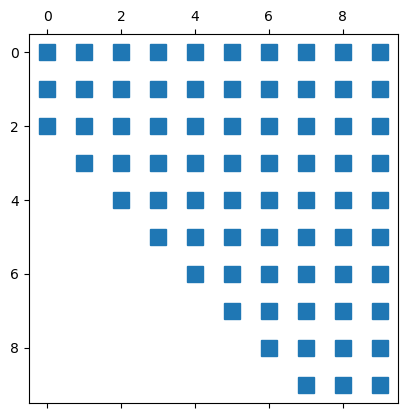

PyObject <matplotlib.lines.Line2D object at 0x0000000001CD5850>

In [19]:
b, c = doubleShift(H[end-1:end,end-1:end])
pH = H*H + b*H + c*I
spy(abs.(pH).>1e-12, markersize = 12)

We need to zero out both subdiagonal entries in the first $n-1$ columns: we can accomplish this with $(n-2)$ $3\times 3$ Householder transformations and one final $2\times 2$ Householder transformation: $$R^{(k)} = (Q^{(k)}_{n-1})^T\cdots (Q^{(k)}_1)^T p(A^{(k-1)}).$$

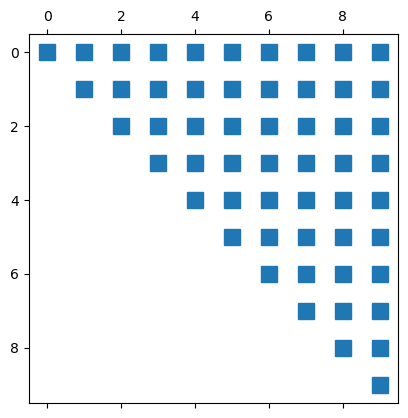

PyObject <matplotlib.lines.Line2D object at 0x000000000125B730>

In [29]:
function doubleHessQR( A )
    n = size(A,2)
    R = copy(A)
    V = zeros(3, n-1)
    for j = 1:n-2
        v = reflector(R[j:j+2,j])
        R[j:j+2,:] = hhtLeft(R[j:j+2,:], v)
        V[:,j] = v
    end
    v = reflector(R[end-1:end,end-1])
    R[end-1:end,:] = hhtLeft(R[end-1:end,:], v)
    V[1:2,end] = v
    return R, V
end

R, V = doubleHessQR( pH )
spy(abs.(R).>1e-12, markersize = 12)

        

Now, we form $A^{(k)} = (Q^{(k)}_{n-1})^T \cdots (Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1\cdots Q^{(k)}_{n-1}$. The key observation here is that $A^{(k)}$ is again upper Hessenberg. The double QR steps preserve the upper Hessenberg structure so that the iterates $A^{(1)}, A^{(2)}, A^{(3)},\ldots,$ are all upper Hessenberg!

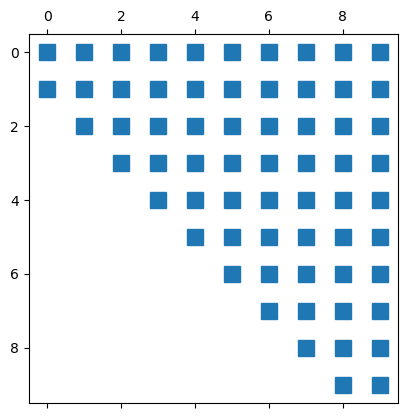

PyObject <matplotlib.lines.Line2D object at 0x00000000013FA970>

In [30]:
H1 = copy(H)
for j = 1:n-2
    H1[j:j+2,:] = hhtLeft(H1[j:j+2,:], V[:,j])
    H1[:,j:j+2] = hhtRight(H1[:,j:j+2], V[:,j])
end
H1[end-1:end,:] = hhtLeft(H1[end-1:end,:], V[1:2,end])
H1[:,end-1:end] = hhtRight(H1[:,end-1:end], V[1:2,end])

spy(abs.(H1).>1e-12, markersize = 12)

How does this help us avoid explicitly forming (and factoring) the double shift polynomial? Let's compute the update step again: $$A^{(k)} = (Q^{(k)}_{n-1})^T \cdots (Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1\cdots Q^{(k)}_{n-1}.$$ But this time we'll look at the pattern of new zeros and nonzeros after applying $Q^{(k)}_1$ from right and left, after applying $Q^{(k)}_2$ from right and left, and so on. 

Here is $(Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1\ldots$

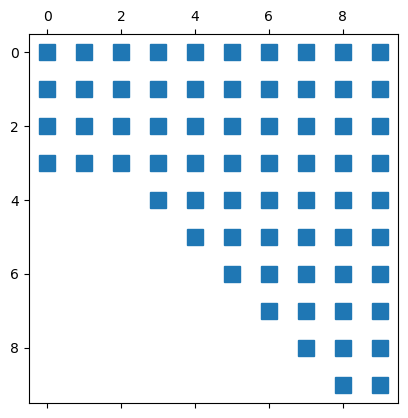

PyObject <matplotlib.lines.Line2D object at 0x00000000012DAB80>

In [31]:
H1 = copy(H)

H1[1:3,:] = hhtLeft(H1[1:3,:], V[:,1])
H1[:,1:3] = hhtRight(H1[:,1:3], V[:,1])

spy(abs.(H1).>1e-12, markersize = 12)

$\ldots$ and here is $(Q^{(k)}_2)^T(Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1Q^{(k)}_2\dots$

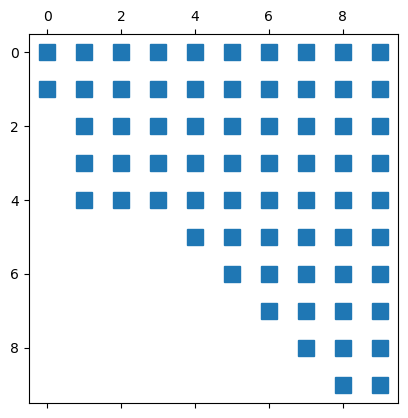

PyObject <matplotlib.lines.Line2D object at 0x000000000133BD90>

In [32]:
H1[2:4,:] = hhtLeft(H1[2:4,:], V[:,2])
H1[:,2:4] = hhtRight(H1[:,2:4], V[:,2])

spy(abs.(H1).>1e-12, markersize = 12)

$\ldots$ and here is $(Q^{(k)}_3)^T(Q^{(k)}_2)^T(Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1Q^{(k)}_2Q^{(k)}_3\dots$

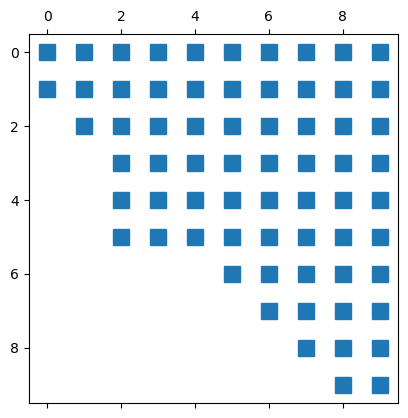

PyObject <matplotlib.lines.Line2D object at 0x000000000139BFA0>

In [33]:
H1[3:5,:] = hhtLeft(H1[3:5,:], V[:,3])
H1[:,3:5] = hhtRight(H1[:,3:5], V[:,3])

spy(abs.(H1).>1e-12, markersize = 12)

$\ldots$ and $(Q^{(k)}_4)^T(Q^{(k)}_3)^T(Q^{(k)}_2)^T(Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1Q^{(k)}_2Q^{(k)}_3Q^{(k)}_4\dots$

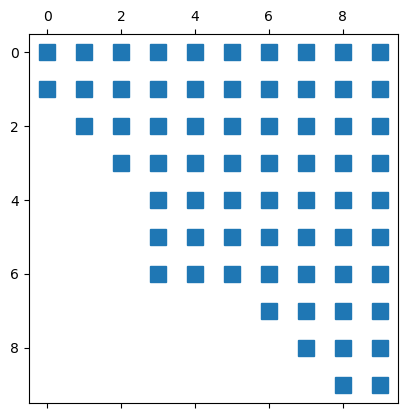

PyObject <matplotlib.lines.Line2D object at 0x000000000140C1F0>

In [34]:
H1[4:6,:] = hhtLeft(H1[4:6,:], V[:,4])
H1[:,4:6] = hhtRight(H1[:,4:6], V[:,4])

spy(abs.(H1).>1e-12, markersize = 12)

Do you see the pattern? The Householder reflections from the QR factorization of the double shift polynomial, when applied sequentially on the left and right, introduce a _bulge_ of nonzero entries on the subdiagonals and _chase_ it down the subdiagonal until the matrix is restored to upper Hessenberg form. After the last few steps of _bulge chasing_, we have the upper Hessenberg matrix $A^{(k)}$.

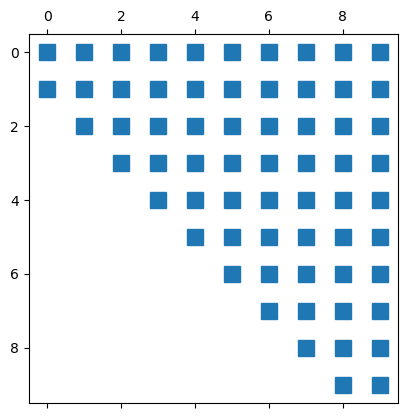

PyObject <matplotlib.lines.Line2D object at 0x00000000014710D0>

In [35]:
for j = 5:n-2
    H1[j:j+2,:] = hhtLeft(H1[j:j+2,:], V[:,j])
    H1[:,j:j+2] = hhtRight(H1[:,j:j+2], V[:,j])
end
H1[end-1:end,:] = hhtLeft(H1[end-1:end,:], V[1:2,end])
H1[:,end-1:end] = hhtRight(H1[:,end-1:end], V[1:2,end])

spy(abs.(H1).>1e-12, markersize = 12)

With this bulge-chasing pattern in hand, we're can outline the _implicit double shift_:
* Compute the *first column only* of the double shift polynomial.
* Determine the Householder reflection $Q^{(k)}_1$ needed to introduce zeros in the first column of the double shift polynomial.
* Apply $(Q^{(k)}_1)^T A^{(k-1)} Q^{(k)}_1$, introducing a "bulge" in the first two columns.
* Compute $Q^{(k)}_2,\ldots,Q^{(k)}_{n-1}$ as required to "chase-the-bulge" down the diagonal and obtain the upper Hessenberg matrix $A^{(k)}$.

Note that the double shift polynomial is not explicitly computed - only the three entries in its first column! After that, we obtain the Householder reflections by bulge chasing _instead of_ explicitly factoring the double shift polynomial. The implicit QR steps cost only $\mathcal{O}(n^2)$ flops.

The mathematical justification for bulge-chasing is the _Implicit Q Theorem_ (it is also sometimes called the Francis Q Theorem), which ensures that the orthogonal factors from the two approaches are essentially the same, up to the column signs. Therefore, the implicitly shifted QR iterations retain all the excellent convergence properties we have seen above!